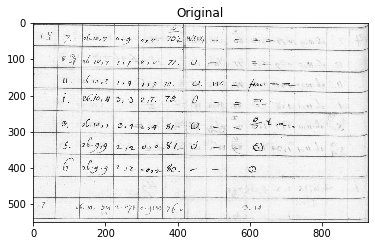

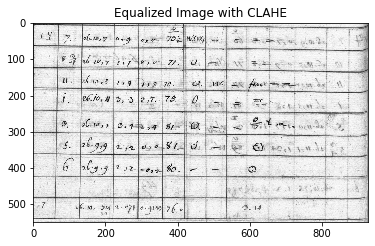

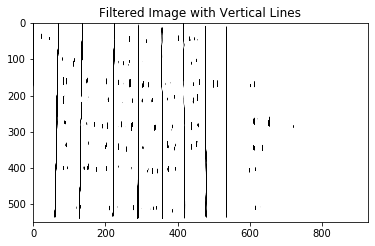

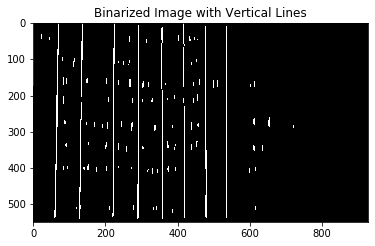

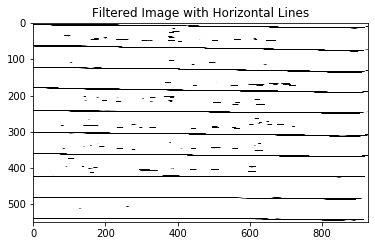

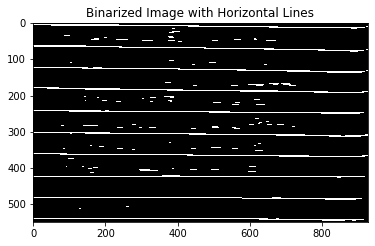

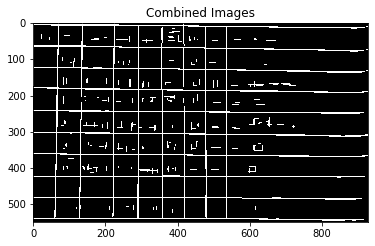

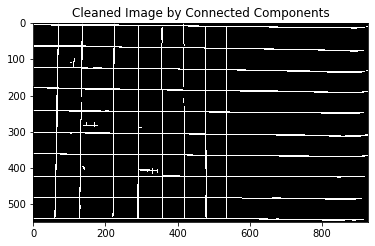

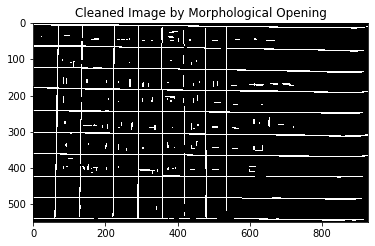

57 remained from 57 after filtering


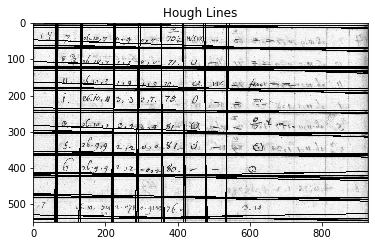

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def _get_kernel(theta) -> float:
    ksize = 31
    return cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)

    
def filter_image(img, theta=np.pi):
    kernel = _get_kernel(theta)
    return cv2.filter2D(img, -1, kernel)


def load_image(path: str):
    return cv2.imread(path)


def invert(img):
    return cv2.bitwise_not(img)


def binarize_image(img):   
    ret, img_binarized = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img_binarized


def equalize_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)


def remove_connected_components(img):
    number_of_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 8, cv2.CV_32S)
    sizes = stats[1:, -1] 
    number_of_labels = number_of_labels - 1
    min_size = 350 
    
    img_cleaned = np.full(img.shape, 0)
    for i in range(0, number_of_labels):
        if sizes[i] >= min_size:
            img_cleaned[labels == i + 1] = 255
            
    return img_cleaned


def moprhological_opening(img):
    kernel = np.ones((3,3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


def _get_coordinates_of_hough_line(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000*(a))
    
    return x1, y1, x2, y2


def get_hough_lines(img_edges, theta=np.pi/180):   
    img_edges = img_edges.astype(np.uint8)
    min_length = 300
    return cv2.HoughLines(img_edges, rho=1.25, theta=theta, threshold=min_length)


def filter_hough_lines(hough_lines):
    hough_lines_filtered = []
    for line in hough_lines:
        for rho, theta in line:
            # print("Theta {} should be between {} {} or {} {}".format(theta, np.pi/180*10, np.pi/180*170, np.pi/180*100, np.pi/180*80))
            # vertical lines
            if theta > (np.pi/180)*170 or theta < (np.pi/180)*10:
                hough_lines_filtered.append(line)
            
            # horizontal lines
            elif theta > (np.pi/180)*80 or theta < (np.pi/180)*100:
                hough_lines_filtered.append(line)
                
    return hough_lines_filtered


def draw_hough_lines(img, hough_lines):
    img_hough_lines = img.copy()
    if hough_lines is not None:
        for line in hough_lines:
            for rho, theta in line:
                x1, y1, x2, y2 = _get_coordinates_of_hough_line(rho, theta)
                cv2.line(img_hough_lines, (x1,y1), (x2,y2), (0, 0, 255), 2)
    return img_hough_lines

    
def show_image(img, title="") -> None:
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.show()
    

def run():
    img = load_image('./assets/scan--no-borders.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show_image(img, "Original")
    
    img_equalized = equalize_image(img.copy())
    show_image(img_equalized, "Equalized Image with CLAHE")
    
    img_filtered = filter_image(img, theta=np.pi)
    show_image(img_filtered, "Filtered Image with Vertical Lines")
    
    img_vertical_binarized = binarize_image(img_filtered.copy())
    img_vertical_binarized = invert(img_vertical_binarized)
    show_image(img_vertical_binarized, "Binarized Image with Vertical Lines")
    
    img_filtered = filter_image(img, theta=np.pi/2)
    show_image(img_filtered, "Filtered Image with Horizontal Lines")
    
    img_horizontal_binarized = binarize_image(img_filtered.copy())
    img_horizontal_binarized = invert(img_horizontal_binarized)
    show_image(img_horizontal_binarized, "Binarized Image with Horizontal Lines")
    
    img_combined = cv2.bitwise_or(img_vertical_binarized, img_horizontal_binarized)
    show_image(img_combined, "Combined Images")
    
    img_cleaned_cc = remove_connected_components(img_combined.copy())
    show_image(img_cleaned_cc, "Cleaned Image by Connected Components")
    
    img_cleaned_morph = moprhological_opening(img_combined.copy())
    show_image(img_cleaned_morph, "Cleaned Image by Morphological Opening")
    
    """
    For maximum accuracy you need a value of 180. To only detect even angles, theta should be 90
    """
    hough_lines = get_hough_lines(img_cleaned_cc, np.pi/180)
    hough_lines_filtered = filter_hough_lines(hough_lines)
    print("{} from {} remained after filtering".format(len(hough_lines_filtered), len(hough_lines)))
    img_hough_lines = draw_hough_lines(img_equalized.copy(), hough_lines)
    show_image(img_hough_lines, "Hough Lines")
    
run()